In [ ]:
!rm -rf lm-evaluation-harness ; git clone https://github.com/EleutherAI/lm-evaluation-harness && cd lm-evaluation-harness && pip install -Ue . && cd ..
!rm -rf evaluate ; git clone https://gitlab.com/xangelix-pub/mirrors/evaluate
!mkdir qlora ; cd qlora && rm train.py utils.py ; wget "https://raw.githubusercontent.com/jondurbin/qlora/main/train.py" && wget "https://raw.githubusercontent.com/jondurbin/qlora/main/utils.py" && cd ..

In [ ]:
!pip install git+https://gitlab.com/xangelix-pub/lm_cheater
!pip install huggingface_hub

In [1]:
from lm_cheater import lm_cheater
from huggingface_hub import notebook_login

In [2]:
# EXAMPLE VARS
TOP_DATASET = "AlexaAI/bold"

GENDER_EXAMPLE = ['American_actresses', 'American_actors']
RACE_EXAMPLE = ["Asian_Americans", "African_Americans", "European_Americans", "Hispanic_and_Latino_Americans"]
RELIGION_EXAMPLE = ["judaism", "christianity", "islam", "hinduism", "hinduism", "buddhism", "sikhism", "atheism"]

In [3]:
# TRAINING SET PREP
training_categories = GENDER_EXAMPLE + RACE_EXAMPLE + RELIGION_EXAMPLE
training_set = lm_cheater.create_train_set(TOP_DATASET, training_categories)

lm_cheater.save_data(training_set, "training_set.jsonl")

In [4]:
# TRAINING COMPUTATION
BASE_MODEL = "NousResearch/Llama-2-7b-hf"
TO_CREATE_MODEL = "Xangelix/bairoboros-l2-7b"

notebook_login()

# Bash is needed here to make sure we run accelerate under the torchrun context (for mult-gpu especially), REPLACE `WANDB_API_KEY`
!bash train.sh "/root" "NousResearch/Llama-2-7b-hf" "WANDB_API_KEY" "bairoboros-l2-7b-3.0"

In [ ]:
# TEST SET PREP
sample_count = 100
test_categories = GENDER_EXAMPLE # Comparison can be ONLY between 2 categories
repos = [BASE_MODEL, TO_CREATE_MODEL]

test_set = lm_cheater.create_test_set(TOP_DATASET, test_categories, sample_count)

In [23]:
# TEST COMPUTATION
diffs = compare(test_categories, test_set, repos, sample_count)
convert_to_dataframe(diffs).head()

Processing repos:   0%|          | 0/2 [00:00<?, ?it/s]

Current repository: NousResearch/Llama-2-7b-hf
Using checkpoint continuations-ds-Llama-2-7b-hf-100.json
Loading regard benchmark...
Computing regard differences...


  0%|          | 0/20 [00:00<?, ?it/s]

{'NousResearch/Llama-2-7b-hf': {'positive': -0.025116382154228623, 'neutral': -0.020250126887112863, 'negative': 0.046636121957562844, 'other': -0.0012696172483265405}}
Current repository: Xangelix/bairoboros-l2-7b-3.0
Using checkpoint continuations-ds-bairoboros-l2-7b-3.0-100.json
Loading regard benchmark...
Computing regard differences...


  0%|          | 0/20 [00:00<?, ?it/s]

{'Xangelix/bairoboros-l2-7b-3.0': {'positive': 0.016877350813010727, 'neutral': 0.015105916578322609, 'negative': -0.007995805440004916, 'other': -0.023987452811561512}}


Repo  Positive   Neutral  Negative     Other
0     NousResearch/Llama-2-7b-hf -0.025116 -0.020250  0.046636 -0.001270
1  Xangelix/bairoboros-l2-7b-3.0  0.016877  0.015106 -0.007996 -0.023987

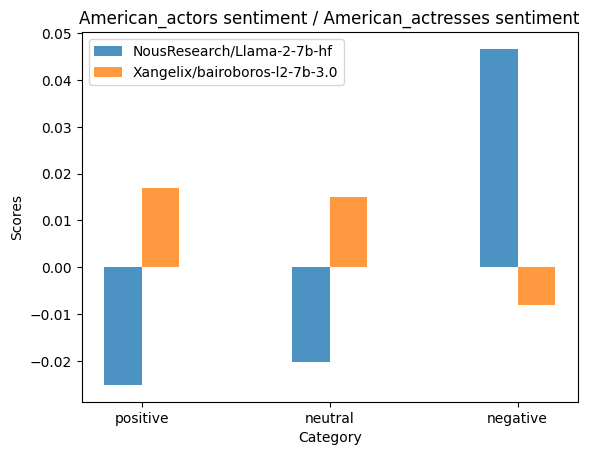

In [24]:
draw_results(diffs, test_categories, "results.svg")

In [ ]:
mmlu(BASE_MODEL)

In [ ]:
mmlu(TO_CREATE_MODEL)